# UMAP for Flow Cytometry

> an application of UMAP on real flow cytometry data for embedding and visualisation

- toc:true
- badges: true
- comments: false
- author:  Marie-Anne Mawhin
- categories: [embedding, dimensionality reduction, flow]

In [4]:
#hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, t

from umap.parametric_umap import ParametricUMAP
from umap.parametric_umap import load_ParametricUMAP

from ipywidgets import widgets, interact, interactive


import umap

Flow cytometry is a powerful technique for phenotypic analysis of cells and cell populations. One main challenge in flow cytometry analysis is to visualise the resulting high-dimensional data to understand data at single-cell levels. 

This is where **dimensionality reduction** techniques come at play, in particular with the advent of spectral and mass cytometry. Most biological data are **non-linear** so using algorithms based on principal component (the famous PCA) will lose local distributions even if they maintain global ones. The most used embedding algorithm (i.e. that transform high-dimension in low-dimension) is currently **t-SNE**, which stands for t-Stochastic Neighbour Embedding. I will tell you here why UMAP killed t-SNE as nicely said in this [article](https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668).

# A little bit about t-SNE before killing it

Let’s start by explaining briefly how t-SNE works:  
Developped by [L.J.P. van der Maaten](https://lvdmaaten.github.io/tsne/),  the algorithm aims is to **minimise the Kullback-Leibler (KL) divergence** between the low-dimensional embedding and the high-dimensional data. The KL divergence can be defined as a measure of how one probability distribution diverges from a second. （；¬＿¬)

### A quick note on KL divergence

Ok, let's plot KL divergence to better understand it using ```scipy.stats norm``` and ```numpy``` for distribution and ```seaborn``` and ```matplotlib.pyplot``` for plotting

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Let's create a little function that plots two normal distribution and calculate the KL:

In [6]:
def kl_divergence(x):
    p = norm.pdf(x, 0, 2)  
    q = norm.pdf(x, 3, 2)
    kl = p * np.log(p /q)
    return p, q, kl

In [7]:
x = np.arange(-10, 10, 0.1)
p, q, kl = kl_divergence(x)

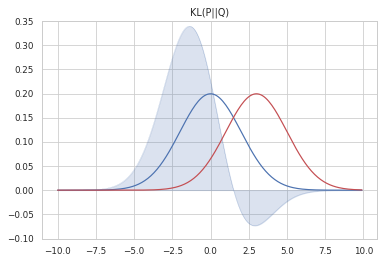

In [8]:
sns.set('paper', 'whitegrid')
plt.plot(x, p, c='b')  
plt.plot(x, q, c='r')
plt.plot(x, kl, lw=0.1, c='b')
plt.fill_between(x, kl, alpha=0.2, color='b')
plt.title('KL(P||Q)')
plt.ylim(-0.1, 0.35)
plt.show()

So the idea is to end up with:

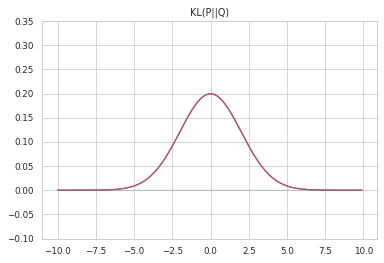

In [9]:
#hide_input
def kl_divergence(x):
    p = norm.pdf(x, 0, 2)  
    q = norm.pdf(x, 0, 2)
    kl = p * np.log(p /q)
    return p, q, kl

x = np.arange(-10, 10, 0.1)
p, q, kl = kl_divergence(x)
sns.set('paper', 'whitegrid')
plt.plot(x, p, c='b')  
plt.plot(x, q, c='r')
plt.plot(x, kl, lw=0.1, c='b')
plt.fill_between(x, kl, alpha=0.2, color='b')
plt.ylim(-0.1, 0.35)
plt.title('KL(P||Q)')
plt.show()

## Steps

1. In **high dimension**, t-SNE tries to determine the **probability of similarity** between each data points. To do so, t-SNE:
- measures the (‘Euclidean’, sort of straight) **distance** between one point to all the other points, pairwise.
- computes a **similarity score using a Gaussian distribution kernel** 🌰: the probability a point x would have another point as neighbour if this neighbour was picked from a normal distribution centred on the point x.
- These similarity scores are then **normalised** to account for cluster density.  
The expected density around each point that determines the width of the kernel is controlled by the **perplexity** parameters.  
- To account for unbalanced density and thus disagreeing scores between two points, the similarity are **symmetrised by averaging** them.  
This gives you a matrix of similarity scores for the high-dimensional data.

2. Following dimension reduction initialisation with PCA or at random, the data are embedded in low **dimension**. The process describe above is performed again but this time to avoid **overcrowding clusters** (all data points ending up in the same area) a **t-distribution** and not a Gaussian is used leaving heavy tails for far apart values.

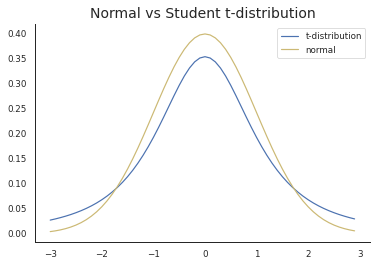

In [14]:
#hide_input
sns.set_style('white')
x1 = np.arange(-3, 3, 0.1)

plt.plot(x1, t(2).pdf(x1))
plt.plot(x1, norm.pdf(x1), c='y')
plt.legend(['t-distribution', 'normal'])
plt.title('Normal vs Student t-distribution', fontsize=14)

sns.despine()

plt.show()



3. The KL divergence cost function is minimised by **gradient descent**, i.e. by small steps.
> The use of KL diverge prevent t-SNE from conserving global distance in low-dimension.

<img src="../images/UMAP/SDG_test-2021-02-02_11.11.57.gif" width="200">

## Parameters

t-SNE has two important hyperparameters to tune:
- ```perplexity```: number of nearest neighbours whose geometric distance is preserved in embedding, i.e. the number of points that you think are in a cluster a minimum that t-SNE will be considering.
> Typical value range from 5-50, but the larger the dataset the larger the perplexity.  
- ```max. number of iteration```: ideally the more the better, but it is limited by computational time. A default value of 1000 is good for exploration.

> Note: t-SNE has a cost function that is not convex, i.e. it can be stuck at a local minima and with different initialisation we can get different results.  

## Pros and cons

Advantages:
- preserves **local structure and clusters**

Disadvantages:
- loss of **global structure**
- **slow computation**
- suffers from **overcrowding in large datasets**

## To go further
For simple and visual explanation, I would recommend [StatQuest](https://www.youtube.com/watch?v=NEaUSP4YerM) from Josh Starmer and this popular [tutorial](https://distill.pub/2016/misread-tsne/)

# UMAP
Uniform Manifold Approximation and Projection or UMAP was developed in 2018 by [McInnes](https://arxiv.org/abs/1802.03426). UMAP has already been integrated into proprietary software for flow analysis democratising its use but its python [library](https://umap-learn.readthedocs.io/en/latest/) offers a wider range of possibility. 

## Steps

1. UMAP builts a graph of the high dimensional data

As t-SNE, UMAP relies on building a **graph** of the high-dimensional data, i.e. a network of **nodes** (point) connected by **edges** (line). The edge are **weighted by the probability of the two points to be connected**. The connection between to points is made when the **radius** around one point **overlap** the radius of another points. 


How to choose the radius? UMAP chooses a radius for each points using the **distance** between the point and its **k-th nearest neighbour**. Then it computes the **likelihood of connection** as inversely proportional to the radius growth, making the **graph 'fuzzy'**. This last point is to solve the **curse of dimensionality** where the distances between points become more similar with higher dimensions.  

To avoid ending up with isolated points and maintaining **local structure**, UMAP ensures that each point is connected to a least its closest neighbour. As in t-SNE, UMAP can generate connections with incompatible weights, however instead of just averaging the weighs UMAP uses the **union** of the two 'fuzzy simplical sets' (⊙_☉). 

![fuzzy](../images/UMAP/canvas.png)

<font size="2"> <span style="color:grey"> Example of fuzzy radii and weighted connections adapted from the [page](https://pair-code.github.io/understanding-umap/) of A.Coenen and A.Pearce </span> </font>

2. UMAP optimises the low dimension

As in t-SNE, the point is to **optimise the low dimension** data (that do not have varying metrics like the high dimension above but Euclidean distances) so they are the closest to the ‘fuzzy’ topology define above. However, to do so instead of using KL divergence, UMAP uses **cross-entropy** as a loss of function. This function is not too far from KL divergence, but, by using attractive and repulsive forces, it maintains **global structure** better.
Moreover, unlike t-SNE, UMAP does not use random initialisation for embedding but **spectral embedding** so UMAP is more **reproducible** from run to run.

> Note: it is still stochastic so it does change a bit.


Finally, UMAP uses **stochastic gradient descent** (mini batch) instead of gradient descent so it is computed faster.

## Parameters

- ```n_neighbors```: number of neighbours for the high dimensional graph. A low value will provides with local structure while a high value will focus on global structure and lose fine details.
- ```min_dist```: minimum distance between points in low dimension,i.e. how tight the points are clustered. Large values results in less pack clusters and loses focus on global structure.

## Pros and cons 
Advantages:
- preserves **local structure and clusters**
- better preservation of **global structure**
- better **reproducibility**
- **fast** runtime

Disadvantages:
- **hyperparameter** choice is crucial and depends on the aims

## To go further
For a really playful and clear detailed explanation, checkout this [website](https://pair-code.github.io/understanding-umap/).

# UMAP for flow cytometry data

UMAP can be used for flow analysis with several aims as described in details in the [doc](https://umap-learn.readthedocs.io/) from UMAP, e.g. to plot high-dimensional data or to reduce dimension before clustering.  
Here, we will explore how UMAP can help in the visualisation of cardiac immune cell response during chronic kidney disease by looking at changes in cardiac leukocyte subtypes.  


## Getting the data ready for it

![](http://25.media.tumblr.com/40db982e13ff34b1be89a713fc7f99d9/tumblr_mgrjtiz4KC1s2yegdo1_400.gif)

### From FlowJo to gated data



A real cool tool available for python is **[Flowkit](https://flowkit.readthedocs.io/en/latest/)**. You can use this tool to extract data that have been gated with GatingML 2.0 or FlowJo 10. I willl focus here on a FlowJo workspace as this is were I did my gating.


To work with FlowJo workspace you need to first call a ```Session``` to get your **FCS** and import your **workspace** in it. Then you need to apply the gating to the **sample group** (the group from your FlowJo workspace structure).

In [ ]:
fks_fj = fk.Session('../data/raw_data')
fks_fj.import_flowjo_workspace('../data/raw_data/FJ_workspace.wsp')
analysis = fks_fj.analyze_samples('group')



To get your labelled gated sampled all you need to do is:

1.Get a dataframe of the gating raw results where in the column events you will have an array of booleans for each gates

In [ ]:
gates = pd.DataFrame(fks_fj.get_gating_results('group', 'sample')._raw_results).loc['events'] #where sample is your sample's name ◔‿◔
gates = pd.DataFrame(gates.droplevel(1)).transpose()

2.Explode the arrays into single rows

In [ ]:
gated = pd.DataFrame()
for col in gates.columns:
    gated[col] = gates[col].explode(ignore_index=True)

3.Merge it back with the fluorescence values of each single cell  


Here you can also select only a subpopulation if you know what is your population of interest (for example not the singlets)

In [ ]:
features  = gated.merge(fkj.get_sample('sample').as_dataframe('raw'), left_index=True, right_index=True)

> Tip: ```fks_fj.get_gate_hierarchy``` is a useful call to check your gating strategy if you have forgotten it

Now that you have extracted your data, there is just one last crucial step.

### Preprocessing: arcsinh

Data from high intensity values are spread on a log scale but the problem with log-scale is that it does not do well on the 'low-end' of the intensity scale, especially since some fluorescence values are zero or sometimes negative (following baseline correction). To solve this problem, bi-exponential transformation have been applied to flow data to approach log for high values and  linearity for data around zero.  
The ArcSinh transform is close to the classic bi-exponential, with a linear representation near zero and a log-like scale beyond a certain threshold, but it is equation-based. The threshold or co-factor determines the compression of the low-end values, the higher the more data are compressed close to zero. Here, data were transformed using **arcsinh with a co-factor of 150** as suggested by [Bendall](https://science.sciencemag.org/content/332/6030/687). 


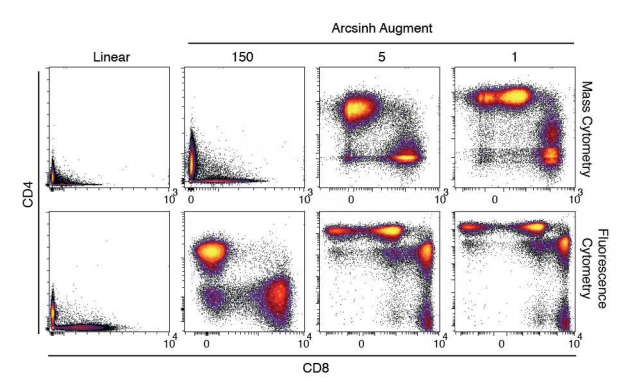

<font size="2"> <span style="color:grey"> Arcsinh transformation adapted from [Bendall et al.](https://science.sciencemag.org/content/332/6030/687) </span> </font>

In [10]:
umap_data = np.arcsinh(features.values / 150.0).astype(np.float32, order='C')

> Note: It is good practice to validate the cofactor value and the transformation by visualising each channel to avoid under/over compression.

## Non-parametric UMAP

Let's explore what UMAP do. The [library](https://umap-learn.readthedocs.io/en/latest/) provides a really detailed documentation and also a nice function to explore UMAP.

In [16]:
#hide
data = pd.read_csv('../../Figure article/UMAP/data/merged_sham_nx.csv')
leuko = data[data.leukocytes].reset_index(drop=True)
leuko.drop(['Unnamed: 0','Singlets 1', 'Singlets 2', 'live', 'cells'], axis=1, inplace=True)

for col in ['R1_', 'R2_', 'R3', 'R4', 'PMNs', 'LIN+', 'CCR2+_']:
    leuko[[col]] = leuko[[col]].replace({True:col, False:''})
    leuko['subtype'] = leuko[[col]]

leuko['subtype'] = leuko[['R1_', 'R2_', 'R3', 'R4', 'PMNs', 'LIN+', 'CCR2+_']].sum(axis=1)

leuko.loc[leuko['subtype'] == '', 'subtype'] = 'leukocytes'
leuko.loc[leuko['subtype'] == 'R2_R4', 'subtype'] = 'R2'
leuko.subtype = leuko.subtype.str.strip('_')

leuko['subtype'] = pd.Categorical(leuko.subtype)

features = leuko[['FSC-W_', 'SSC-W_', 'BV421-A_Lin',
                                      'BV510-A_Ly6C', 'FITC-A_F4/80', 'BV605-A_Ly6G', 'PE-Cy7-A_CD11b',
                                      'BV 785-A_CD45', 'APC-A_MHCII', 
                                      'PE-A_CCR2']]

umap_data = np.arcsinh(features.values / 150.0).astype(np.float32, order='C')

In [17]:
import umap.plot
import umap


def draw_umap(n_neighbors=15, min_dist=0.1, metric='euclidean', title=''):
    mapper = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric=metric,
        random_state=2
    ).fit(umap_data)
    umap.plot.points(mapper, labels=leuko.subtype, theme='blue', width=400, height=400)
    plt.title(title, fontsize=18)
    plt.show()

In [18]:
#hide_input
@interact(n_neighbors=(10, 100, 10), min_dist=[0.0, 0.1, 0.25, 0.5])
def plot_umap(n_neighbors, min_dist):
    draw_umap(n_neighbors=n_neighbors, min_dist=min_dist, title=f'n_neighbors = {n_neighbors}\nmin_dist = {min_dist}')

interactive(children=(IntSlider(value=50, description='n_neighbors', min=10, step=10), Dropdown(description='m…

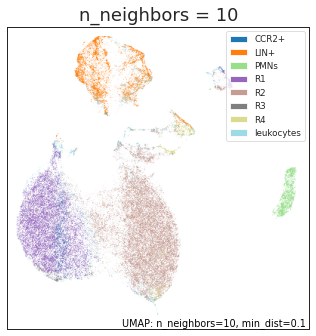

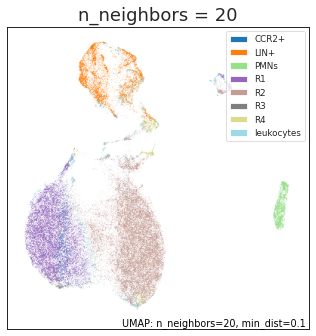

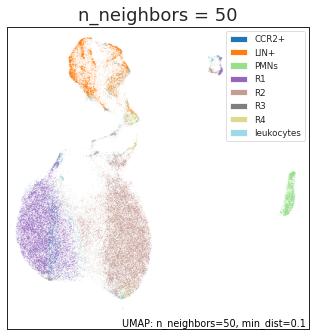

In [19]:
for n in (10, 20, 50):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

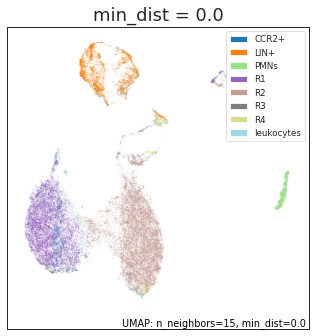

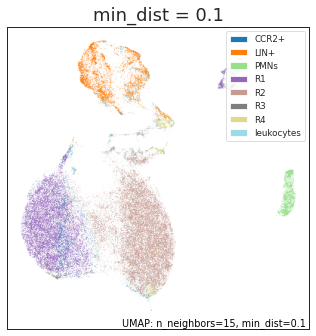

KeyboardInterrupt: 

In [20]:
for d in (0.0, 0.1, 0.25):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

### Clustering with Kmeans

In [54]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(umap_data)

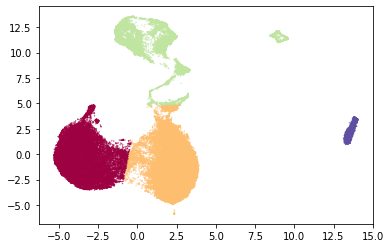

In [57]:
kmeans_labels = cluster.KMeans(n_clusters=4).fit_predict(clusterable_embedding)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

### Diagnostic and connectivity

In [69]:
%time 
mapper = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='cosine',
        random_state=42).fit(umap_data)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


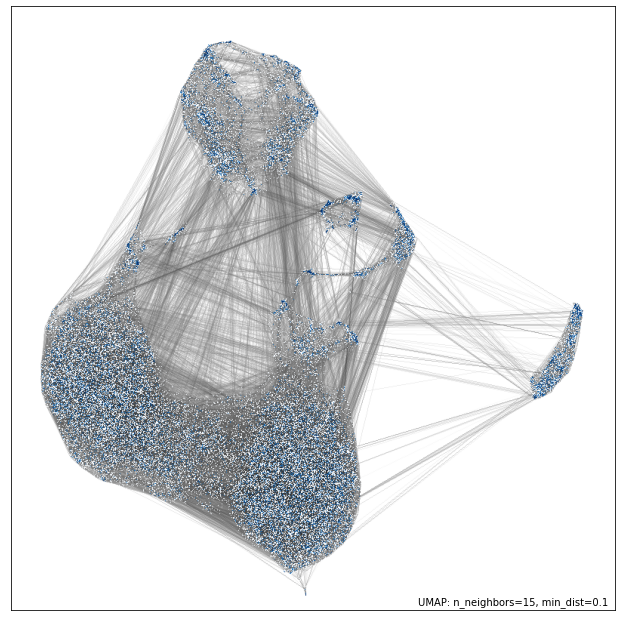

In [70]:
umap.plot.connectivity(mapper, show_points=True)

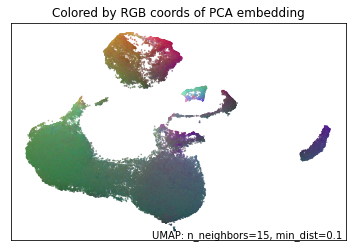

In [71]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

In [60]:
#hide
embedder_1 = load_ParametricUMAP('models/embedder_1//')

FileNotFoundError: [Errno 2] No such file or directory: 'models/embedder_1//model.pkl'

In [61]:
#hide
graph = pd.concat([pd.DataFrame(embedder_1.embedding_, columns=['UMAP 1', 'UMAP 2']), leuko[['sample', 'subtype']]], axis=1).sort_values('subtype')
graph = graph.replace({'R1':'F4/80⁺MHCIIʰᶦ', 'R2':'F4/80⁺MHCIIˡᵒ','R3':'Ly6C⁺MHCIIʰᶦ','R4':'Ly6C⁺',
                      'CCR2+':'F4/80⁺MHCIIʰᶦCCR2⁺','PMNs':'neutrophils','LIN+':'lymphocytes'})
graph.subtype.unique()

NameError: name 'embedder_1' is not defined

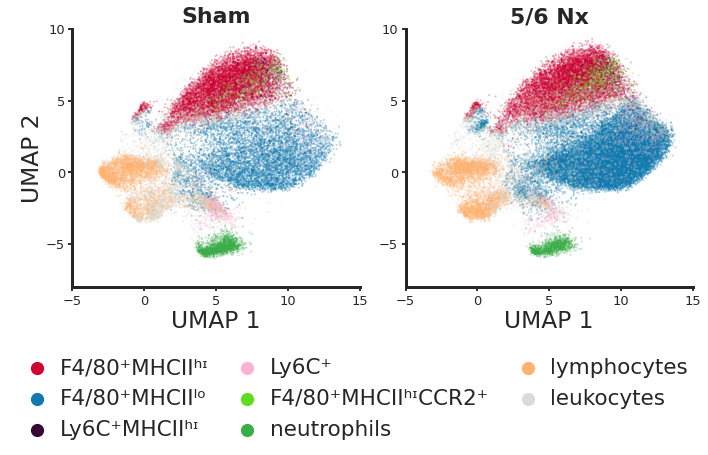

In [28]:
sns.set(font_scale=1.3, style='ticks', context='talk', font='Arial', 
        rc={"axes.linewidth": 3,
           "xtick.major.size": 4, "ytick.major.size": 4,
            'legend.handletextpad': 0.05,
            'legend.markerscale': 1.3,
            'axes.labelpad': 2.0,
            'legend.columnspacing': 0.8,
            })

g = sns.relplot(x='UMAP 1', y='UMAP 2', data=graph, hue='subtype', col='sample', col_order=['sham', 'nx'],
            s=4, alpha=0.3, marker='o',
            linewidth=0, 
            palette=sns.xkcd_palette(['cherry', 'nice blue', 'eggplant', 'powder pink',
                                     'green apple', 'medium green', 'apricot', 'light grey']),
            facet_kws={'sharey': False,
                      'legend_out': True}, 
               )

for ax, title in zip(g.axes.flat, ['Sham', '5/6 Nx']):
    ax.set_title(title, fontsize=22, fontweight='semibold')

    
g._legend.set_title('')
g.set_xticklabels(fontsize=13)
g.set_yticklabels(fontsize=13)
g.set(ylim=(-8, 10))
plt.subplots_adjust(wspace=0.16)
g._legend.remove()
h, l = g.axes[0,0].get_legend_handles_labels()
plt.legend(h, l , ncol=3, bbox_to_anchor=(1.05, -0.2), frameon=False)